# Parallel Computing

Parallel computing is a programming method that **harnesses the power of multiple processors (or cores) at once**. Once of concern only to programmers of large supercomputers, modern computers now almost always have multi-core processors. However:

> At the heart of efficient parallel code is fast serial code!!

### How many CPU cores do I have?

In [2]:
using Hwloc
Hwloc.num_physical_cores()

6

(Note that `Sys.CPU_THREADS` may or may not be equal to the number above. It indicates the number of CPUs + Hyperthreads.)

### Why go parallel?

<img src="imgs/42-years-processor-trend.svg" width=700px>

### **Amdahl's Law**

Naive expectation: I have 4 cores, give me my 4x speedup!

>If $p$ is the fraction of a code that can be parallelized than the maximal theoretical speedup by parallelizing on $n$ cores is given by $F(n) = 1/(1-p + p/n)$.

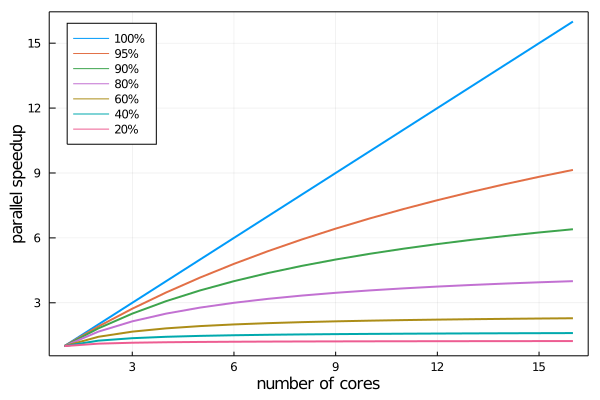

In [3]:
using Plots
F(p,n) = 1/(1-p + p/n)

pl = plot()
for p in reverse(sort(vcat(0.2:0.2:1, [0.9, 0.95])))
    plot!(pl, n -> F(p,n), 1:16, lab="$(Int(p*100))%", lw=2,
        legend=:topleft, xlab="number of cores", ylab="parallel speedup", frame=:box)
end
pl

# Parallel Computing in Julia

Julia documentation link: [Parallel computing](https://docs.julialang.org/en/v1/manual/parallel-computing/index.html)

There are many types of parallelism, some of which are (from micro to macro)

* **Instruction level parallelism**
* **Multi-threading** (process shared memory)
* **Tasks aka Coroutines** aka Green threads (more like cooperative multitasking, process shared memory)
* **Multi-Core processing** (maybe system shared memory)
* **Distributed processing** (same as above but involving multiple machines)

Julia provides (more or less) native support for all of these forms of parallel processing (same order as above)

* `@simd` and [SIMD.jl](https://github.com/eschnett/SIMD.jl)
* `Base.Threads.@threads` (experimental since 2015 but seems to be fine)
* `@async`, `@sync`, `Channel`
* `@spawnat`, `@fetch`, `RemoteChannel`, `SharedArray`, etc.
* `@spawnat`, `@fetch`, `RemoteChannel`, `DArray`, `MPI.jl` etc.

With scientific computing in mind, we will mainly focus on how to distribute a process through multiple cores or machines (our thp cluster for example), that is **Multi-Core processing** and **Distributed processing**. But before we can do so, we have to learn how to control Julia's control flow through tasks.

# Tasks (Control flow)

By default, Julia waits for every command to finish and run everything sequentially.

Tasks are a control flow feature that allows computations to be **suspended** and resumed in a flexible manner. This feature is sometimes called by other names, such as coroutines, green or lightweight threads and cooperative multitasking.

To me, the name **cooperative multitasking** is the most descriptive. Tasks are managed/scheduled by Julia and can sometimes be run in a quasi-parallel fashion.

An important use case is **asynchronous I/O**, which is typically slow. Examples are
 * **multiple user input** (Why not already process some of the input?)
 * **data dumping to disk** (Maybe it's possible to continue a calculation?)
 * **receiving calculations from worker processes** (We'll need that below!)

How do we execute commands asynchronously?

## `@async` and `@sync`

(Based on [this](https://stackoverflow.com/questions/37287020/how-and-when-to-use-async-and-sync-in-julia/37287021#37287021) stackoverflow answer.)

In [2]:
?@async

```
@async
```

Wrap an expression in a [`Task`](@ref) and add it to the local machine's scheduler queue.

Values can be interpolated into `@async` via `$`, which copies the value directly into the constructed underlying closure. This allows you to insert the *value* of a variable, isolating the aysnchronous code from changes to the variable's value in the current task.

!!! compat "Julia 1.4"
    Interpolating values via `$` is available as of Julia 1.4.



What this means is that for whatever falls within its scope, Julia will start a task to then proceed to whatever comes next in the script **without waiting for the task to complete**.

In [3]:
@time sleep(2);

  2.001227 seconds (63 allocations: 1.656 KiB)


In [4]:
@time @async sleep(2)

  0.005359 seconds (6.19 k allocations: 362.957 KiB)


Task (runnable) @0x000000012bb81d50

Julia allows the script to proceed (and the `@time` macro to fully execute) without waiting for the task (in this case, sleeping for two seconds) to complete.

We can use the `@sync` macro to synchronize, that is wait for, all encapsulated tasks. (see `?@sync`). 

In [5]:
@time @sync @async sleep(2)

  2.023424 seconds (1.60 k allocations: 88.344 KiB)


Task (done) @0x000000011213c6d0

Of course, here it doesn't make much sense to write `@sync @async` - we could simply drop it altogether.

A better example is the following.

In [6]:
@time @sync begin
    @async sleep(2.0)
    @async sleep(2.0)
end

  2.009667 seconds (3.66 k allocations: 175.727 KiB)


Task (done) @0x000000011213fcd0

In [7]:
@sync begin
    @async (sleep(2); println("Today is reverse day!"))
    @async (sleep(1); println(" class!"))
    @async print("Hello")
end;

Hello class!
Today is reverse day!


# Distributed processing: Multi-core

Distributed computing in Julia means having **multiple separate Julia instances running on different cores** on the same or different machines.

Data movement and communication between processes is explicit.

Let's focus on the *multi-core* case (your laptop/desktop) and save some cluster fun for later.

## Master-worker model

Julia uses a *master-worker* paradigm for its native distributed parallelism.

One master process coordinates all the worker processes, which perform the actual computations.

By default, Julia starts with one process on one core. If this single process is all we have, than it is both the master and the worker.

In [8]:
using Distributed # Loading all tools that we need for distributed computing

In [9]:
nprocs()

1

In [10]:
nworkers() # the master is considered a worker as long as there are no real workers

1

To increase the number of workers, i.e. Julia processes, from within a Julia session we can use `addprocs`.

Alternatively, when starting Julia from the command line, one can use the `-p` option. Example,

```
julia -p 4
```

will start Julia with 5 processes, 1 master and 4 workers.

In [11]:
addprocs(4) # I have 4 cores, so let's add 4 worker processes.

4-element Array{Int64,1}:
 2
 3
 4
 5

Every process has a Julia internal `pid` (process id). The master is always 1. You can get the workers pids from `workers()`.

In [12]:
workers()

4-element Array{Int64,1}:
 2
 3
 4
 5

Note that the 4 worker's pids aren't necessarily 2, 3, 4 and 5. Let's remove the processes and add them once more.

In [13]:
rmprocs(workers()) # rmprocs(array of pids of worker processes to remove)

Task (done) @0x0000000114dd7610

In [14]:
nworkers() # only the master is left

1

In [15]:
addprocs(4)

4-element Array{Int64,1}:
 6
 7
 8
 9

In [16]:
workers()

4-element Array{Int64,1}:
 6
 7
 8
 9

## One master to rule them all - `@spawn`, `@spawnat`, `@fetch`, `@fetchfrom`, `@everywhere`...

To execute commands and start computations on workers we can use the following macros

* `@spawn`: run a command or a code block on any worker and return a `Future` to it's result. It's basically a version of `@async` for remote processes.
* `@spawnat`: same as `@spawn` but one can choose a specific worker by providing its pid.

**Example:** Let's say we would like to generate a random matrix on one of the workers.

In [17]:
@spawn rand(2,2) # basically @async for remote process, i.e. returns immediately

Future(6, 1, 10, nothing)

In [18]:
result = @spawn rand(2,2)

Future(7, 1, 11, nothing)

In [19]:
fetch(result) # blocks, like @sync

2×2 Array{Float64,2}:
 0.945718  0.118221
 0.502309  0.306951

Because the combination of spawning at fetching is so common, there is `@fetch` which combines them.

In [20]:
@fetch rand(2,2)

2×2 Array{Float64,2}:
 0.64063    0.696818
 0.0786571  0.125802

Which worker did the work?

In [21]:
@fetch begin
    println(myid());
    rand(2,2)
end

      From worker 9:	9


2×2 Array{Float64,2}:
 0.275432  0.482214
 0.39933   0.245722

Using `@spawnat` and `@fetchfrom` we can delegate the work to a specific worker.

In [22]:
@fetchfrom 7 begin
    println(myid());
    rand(2,2)
end

      From worker 7:	7


2×2 Array{Float64,2}:
 0.251919  0.642161
 0.583157  0.469428

We can use `@sync` as a blocker to wait for all workers to complete their tasks.

In [23]:
@sync begin
    pids = workers()
    @spawnat pids[1] (sleep(2); println("Today is reverse day!"))
    @spawnat pids[2] (sleep(1); println(" class!"))
    @spawnat pids[3] println("Hello")
end;
println("Done!")

      From worker 8:	Hello
      From worker 7:	 class!
      From worker 6:	Today is reverse day!
Done!


Ok, now that we understood all that, let's delegate a *complicated* calculation

In [24]:
using Random

function complicated_calculation()
    sleep(1) # so complex that it takes a long time :)
    randexp(5)
end

@fetch complicated_calculation()

LoadError: On worker 6:
UndefVarError: #complicated_calculation not defined
deserialize_datatype at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Serialization/src/Serialization.jl:1252
handle_deserialize at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Serialization/src/Serialization.jl:826
deserialize at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Serialization/src/Serialization.jl:773
handle_deserialize at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Serialization/src/Serialization.jl:833
deserialize at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Serialization/src/Serialization.jl:773 [inlined]
deserialize_global_from_main at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Distributed/src/clusterserialize.jl:180
#3 at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Distributed/src/clusterserialize.jl:72 [inlined]
foreach at ./abstractarray.jl:2009
deserialize at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Distributed/src/clusterserialize.jl:72
handle_deserialize at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Serialization/src/Serialization.jl:919
deserialize at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Serialization/src/Serialization.jl:773
handle_deserialize at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Serialization/src/Serialization.jl:830
deserialize at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Serialization/src/Serialization.jl:773
handle_deserialize at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Serialization/src/Serialization.jl:833
deserialize at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Serialization/src/Serialization.jl:773 [inlined]
deserialize_msg at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Distributed/src/messages.jl:99
#invokelatest#1 at ./essentials.jl:710 [inlined]
invokelatest at ./essentials.jl:709 [inlined]
message_handler_loop at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Distributed/src/process_messages.jl:185
process_tcp_streams at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Distributed/src/process_messages.jl:142
#99 at ./task.jl:356

What happened?

**Think of every worker as a separate Julia instance.**

We only defined `complicated_calculation()` on the master process. The function doesn't exist on any of the workers yet.

The macro `@everywhere` comes for the rescue.

In [25]:
@everywhere begin # execute this block on all workers
    using Random
    
    function complicated_calculation()
        sleep(1)
        randexp(5) # lives in Random
    end
end

In [26]:
@fetch complicated_calculation()

5-element Array{Float64,1}:
 0.9929244532610297
 0.006867164623105961
 0.1750912406254631
 0.13884546798047914
 1.7236895962591872

## Data movement

There is a crucial difference between the following two pieces of code. Can you guess what it is?

In [27]:
function method1()
    A = rand(100,100)
    B = rand(100,100)
    C = @fetch A^2 * B^2
end

method1 (generic function with 1 method)

In [28]:
function method2()
    C = @fetch rand(100,100)^2 * rand(100,100)^2
end

method2 (generic function with 1 method)

Let's benchmark them.

In [29]:
using BenchmarkTools
@btime method1();
@btime method2();

  671.713 μs (141 allocations: 239.16 KiB)
  410.030 μs (115 allocations: 82.17 KiB)


Method 1 is slower, because `A` and `B` are created on the master process, transferred to a worker, and squared and multiplied on the worker process before the result is finally transferred back to the master.

Method 2, on the other hand, creates, squares, and multiplies the random matrix all on the work process and only submits the result to the master.

Hence, `method1` is **transferring 3x as much data** between the master and the worker!

**Data movement is crucial!**

In this toy example, it's rather easy to identify the faster method.

In a real program, however, understanding data movement does require more thought and likely some measurement.

For example, if the first process needs matrix `A` in a follow-up computation then the first method might be better in this case. Or, if computing `A` is expensive and only the current process has it, then moving it to another process might be unavoidable.

#### Computer latency at a human scale

To understand why thinking about data is important it's instructive to look at the time scales involved in data access.

<img src="imgs/latency_human_scales.png" width=900px>

(taken from https://www.prowesscorp.com/computer-latency-at-a-human-scale/)

### Avoid globals (once more)

In [30]:
myglobal = 4

4

In [31]:
function whohas(s::String)
    @everywhere begin
        var = Symbol($s)
        if isdefined(Main, var)
            println("$var exists.")
        else
            println("Doesn't exist.")
        end
    end
    nothing
end

whohas (generic function with 1 method)

In [32]:
whohas("myglobal")

      From worker 6:	Doesn't exist.
      From worker 9:	Doesn't exist.
      From worker 7:	Doesn't exist.
      From worker 8:	Doesn't exist.
myglobal exists.


In [33]:
@fetchfrom 6 myglobal+2

6

In [34]:
whohas("myglobal")

myglobal exists.
      From worker 7:	Doesn't exist.
      From worker 8:	Doesn't exist.
      From worker 9:	Doesn't exist.
      From worker 6:	myglobal exists.


Globals get copied to workers and continue to exist as globals even after the call.

This could lead to memory accumulation if many globals are used (just as it would in a single Julia session).

It's better to avoid them.

## Explicit data movement: `Channel` and `RemoteChannel`

Channels in Julia are constructs to explicitly exchange data between workers.

They implement `put!`, `take!`, `fetch`, `isready` and `wait` methods.

In [35]:
# ?Channel

In [36]:
ch = Channel{Int}(5) # a channel that can hold up to 5 integers

Channel{Int64}(sz_max:5,sz_curr:0)

In [37]:
isready(ch) # something in the channel?

false

In [38]:
put!(ch, 3)

3

In [39]:
isready(ch)

true

In [40]:
take!(ch)

3

In [41]:
isready(ch)

false

In [42]:
put!(ch, 4)

4

In [43]:
fetch(ch) # basically take without a bang

4

In [44]:
take!(ch)

4

Be careful, `take!` and `put!` are blocking if the channel is empty or full!

In [45]:
isready(ch)

false

In [46]:
# take!(ch) if we execute this, while isready(ch) == false, the current Julia session will hang.

## Channels for inter-process data movement: `RemoteChannel`

* A `Channel` is local to a process. Worker 2 cannot directly refer to a `Channel` on worker 3 and vice-versa.


* A `RemoteChannel`, however, can put and take values across workers. A `RemoteChannel` can be thought of as a handle to a `Channel`.


* Any process with a reference to a `RemoteChannel` can put and take items from the channel. Data is automatically sent to (or retrieved from) the process a `RemoteChannel` is associated with.


* The process id, pid, associated with a `RemoteChannel` identifies the process where the backing store, i.e., the backing Channel exists.

In [47]:
nworkers()

4

In [48]:
addprocs(4)

4-element Array{Int64,1}:
 10
 11
 12
 13

In [49]:
?RemoteChannel

search: RemoteChannel



```
RemoteChannel(pid::Integer=myid())
```

Make a reference to a `Channel{Any}(1)` on process `pid`. The default `pid` is the current process.

```
RemoteChannel(f::Function, pid::Integer=myid())
```

Create references to remote channels of a specific size and type. `f` is a function that when executed on `pid` must return an implementation of an `AbstractChannel`.

For example, `RemoteChannel(()->Channel{Int}(10), pid)`, will return a reference to a channel of type `Int` and size 10 on `pid`.

The default `pid` is the current process.


In [50]:
# creates a channel on the second worker process
# create a RemoteChannel handle to this channel on the master process
const mychannel = RemoteChannel(()->Channel{Int}(10), workers()[2])

RemoteChannel{Channel{Int64}}(7, 1, 22309)

In [51]:
whohas("mychannel")

      From worker 6:	Doesn't exist.
      From worker 8:	Doesn't exist.
      From worker 9:	Doesn't exist.
      From worker 7:	Doesn't exist.
mychannel exists.
      From worker 10:	Doesn't exist.
      From worker 11:	Doesn't exist.
      From worker 12:	Doesn't exist.
      From worker 13:	Doesn't exist.


In [52]:
# One could create a global constant mychannel everywhere
@everywhere const mychannel = $mychannel

In [53]:
whohas("mychannel")

      From worker 6:	mychannel exists.
      From worker 8:	mychannel exists.
      From worker 11:	mychannel exists.
      From worker 12:	mychannel exists.
      From worker 13:	mychannel exists.
      From worker 9:	mychannel exists.
mychannel exists.
      From worker 10:	mychannel exists.
      From worker 7:	mychannel exists.


However, as we said many times before, one should generally try to avoid globals. The following is preferable.

In [54]:
function do_something()
    rc = RemoteChannel(()->Channel{Int}(10)) # lives on the master
    @sync for p in workers()
        @spawnat p put!(rc, myid())
    end
    rc
end

r = do_something()

RemoteChannel{Channel{Int64}}(1, 1, 22359)

In [55]:
isready(r)

true

In [56]:
while isready(r)
    @show take!(r)
end

take!(r) = 8
take!(r) = 9
take!(r) = 6
take!(r) = 7
take!(r) = 10
take!(r) = 11
take!(r) = 12
take!(r) = 13


The ecosystem also contains a couple of tools, that make data transfer even simpler. See for example [ParallelDataTransfer.jl](https://github.com/ChrisRackauckas/ParallelDataTransfer.jl/).

# Parallelizing the easy way - `@distributed` and `pmap`

So far we have seen the build block of commands for distributed computing in Julia. Having scientific computing in mind, one might not always want to think about how to distribute the work and explicitly spawn tasks.

Also, fortunately, many useful parallel computations do not require (much) data movement. A common example is a direct Monte Carlo simulation, where multiple processes can handle independent simulation trials simultaneously. (We'll get to that later!)

Julia provides convenience macros to
 * Parallelize loops (`@distributed`)
 * Apply a function to all elements in some collection (`pmap`)
 
Let's explore these!

## Distributed loops (`@distributed`)

In [57]:
using Distributed, BenchmarkTools; rmprocs(workers()); addprocs(4); nworkers()

4

In [59]:
# serial version - count heads in a series of coin tosses
function add_serial(n)
    c = 0
    for i = 1:n
        c += rand(Bool)
    end
    c
end

@btime add_serial(200_000_000);

  1.252 s (0 allocations: 0 bytes)


This is trivially parallelizable since the loop iterations are independent of each other. We can distribute coin tosses over a couple of workers.

Afterwards we combine the results, that is we sum them up. The combination process is generally called a *reduction*, and in this case `sum` is the *reducer function*.

To distribute the for loop over worker processes Julia provides the `@distributed` macro:

In [60]:
?@distributed

```
@distributed
```

A distributed memory, parallel for loop of the form :

```
@distributed [reducer] for var = range
    body
end
```

The specified range is partitioned and locally executed across all workers. In case an optional reducer function is specified, `@distributed` performs local reductions on each worker with a final reduction on the calling process.

Note that without a reducer function, `@distributed` executes asynchronously, i.e. it spawns independent tasks on all available workers and returns immediately without waiting for completion. To wait for completion, prefix the call with [`@sync`](@ref), like :

```
@sync @distributed for var = range
    body
end
```


In [61]:
# distributed version
function add_distributed(n)
    c = @distributed (+) for i in 1:n
        Int(rand(Bool))
    end
    c
end

@btime add_distributed(200_000_000);

  362.303 ms (413 allocations: 16.95 KiB)


The distributed version is about **4x faster**, which is all we could hope for.

Let's see who is doing the work

In [62]:
# verbose distributed version
function add_distributed(n)
    c = @distributed (+) for i in 1:n
        x = Int(rand(Bool))
        println(x);
        x
    end
    c
end

add_distributed(8);

      From worker 15:	0
      From worker 14:	1
      From worker 15:	1
      From worker 17:	1
      From worker 14:	0
      From worker 17:	0
      From worker 16:	1
      From worker 16:	0


Apparently, the work is evenly distributed between the workers. By using `@distributed` we let Julia decide how to split up the work and can't control it ourselves.

A common mistake when using `@distributed` is the following:

In [63]:
function f(n)
    a = 0
    @distributed (+) for i in 1:n
        a += 1
    end
    a
end

a = f(10);

What do you expect the value of `a` to be?

In [64]:
a

0

We can (sort of) see what's happening by making everything global

In [65]:
a = 0
@distributed (+) for i in 1:10
    println("1")
    global a += 1
end;

      From worker 14:	1
      From worker 15:	1
      From worker 14:	1
      From worker 15:	1
      From worker 15:	1
      From worker 17:	1
      From worker 14:	1
      From worker 17:	1
      From worker 16:	1
      From worker 16:	1


In [66]:
@everywhere @show a

a = 0
      From worker 17:	a = 2
      From worker 15:	a = 3
      From worker 16:	a = 2
      From worker 14:	a = 3


The variable `a` gets copied to the worker processes as it is referenced in the distributed loop. 

Every worker will then increment its copy of `a`.

However, we do not save the result of the reduction (sum) but instead return `a` from the master process, which hasn't been altered at all.

Corrected version:

In [67]:
function f2(n)
    a = @distributed (+) for i in 1:n
        1
    end
    a
end

a = f2(10)

10

### What if I don't want to reduce?

Similar to the mistake above, the following example might not have the effect one expects. **Why?**

In [68]:
a = zeros(10)
@distributed for i = 1:10
    a[i] = i
end

Task (runnable) @0x0000000112288010

In [69]:
@everywhere @show a

a = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
      From worker 17:	a = [0.0, 0.0, 0.0, 4.0, 5.0, 6.0, 0.0, 0.0, 0.0, 0.0]
      From worker 15:	a = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 10.0]
      From worker 16:	a = [1.0, 2.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
      From worker 14:	a = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 8.0, 0.0, 0.0]


Note that `@distributed` without a reduction function returns a `Task`. It is basically a distributed version of `@spawn` for all the iterations.

## `SharedArray`s

To actually make all processes operate on the same array, one can use a `SharedArray`.

Note that a `SharedArray` only works if the **processes live on the same host**.

The constructor of a SharedArray is

```julia
SharedArray{T,N}(dims::NTuple; init=false, pids=Int[])
```

which creates an `N`-dimensional shared array of a (bits) type `T` and size `dims` across the processes specified by `pids`.

(If an `init` function, of signature `initfn(S::SharedArray)`, is specified, it is called on all the participating workers. You can specify that each worker runs the init function on a distinct portion of the array, thereby parallelizing initialization.)

In [70]:
@everywhere using SharedArrays # must be loaded everywhere

In [71]:
A = rand(2,3)

2×3 Array{Float64,2}:
 0.567059  0.3247    0.778413
 0.563554  0.657174  0.707632

In [72]:
S = SharedArray(A)

2×3 SharedArray{Float64,2}:
 0.567059  0.3247    0.778413
 0.563554  0.657174  0.707632

Ok, now that we know how to create and fill our `SharedArray` we can create a parallel fill function:

In [73]:
function fill_shared_problematic(N)
    S = SharedMatrix{Float64}(N,N)
    @distributed for i in 1:length(S)
        S[i] = i
    end
    S
end

fill_shared_problematic(3)

3×3 SharedArray{Float64,2}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

*Why is the method in its current form problematic? Try to find out yourself by going to larger `N` and, for example, inspecting the minimum of the returned `SharedArray`!*

Going to larger matrix sizes....

In [74]:
function fill_shared_problematic(N)
    S = SharedMatrix{Int64}(N,N)
    @distributed for i in 1:length(S)
        S[i] = i
    end
    S
end

S = fill_shared_problematic(100)
minimum(S)

0

Note how sometimes the array isn't completely filled but still contains zeros. This is because it isn't filled **yet**!

Check again!

In [75]:
minimum(S)

1

We can use `@sync` to synchronize our distributed for loop.

In [76]:
function fill_shared_problematic(N)
    S = SharedMatrix{Int64}(N,N)
    @sync @distributed for i in 1:length(S) # added @sync here
        S[i] = i
    end
    S
end

S = fill_shared_problematic(100)
minimum(S)

1

Ok, let's **benchmark** this for a larger matrix size

In [77]:
# regular array
function fill_regular(N)
    A = Matrix{Int64}(undef,N,N)
    for i in 1:length(A)
        A[i] = i
    end
    A
end

@time fill_regular(10000);

  0.493256 seconds (181.83 k allocations: 772.425 MiB, 1.02% gc time)


In [78]:
# shared array
function fill_shared(N)
    S = SharedMatrix{Int64}(N,N)
    @sync @distributed for i in 1:length(S)
        S[i] = i
    end
    S
end

@time fill_shared(10000);

  0.216491 seconds (151.44 k allocations: 7.594 MiB)


This is of course just filling an array.

If there were actual calculations it might actually be beneficial to distribute the work across workers.

## Parallel map: `pmap`

Sometimes we merely wish to apply a function to all all elements in a collection.

For those cases, Julia provides the `pmap` (parallel map) function.

Say, we want to compute the singular values of a bunch of larger matrices in parallel.

In [4]:
using Distributed, BenchmarkTools; rmprocs(workers()); addprocs(Hwloc.num_physical_cores()); nworkers()

6

In [23]:
@everywhere using LinearAlgebra

M = Matrix{Float64}[rand(200,200) for i = 1:10];

pmap(svdvals, M)

10-element Array{Array{Float64,1},1}:
 [99.97891570057692, 8.034814472373226, 7.893431959027469, 7.754265789018793, 7.725025299718543, 7.668759865482055, 7.601028863940719, 7.369710170994251, 7.291812522361135, 7.283898104715084  …  0.3033420356831123, 0.2476499225414878, 0.23624827173877505, 0.19096120698439642, 0.1618735084284694, 0.14885328170661546, 0.09280994674833183, 0.04725557390642475, 0.019059727369299898, 0.0045790103539736305]
 [100.73166052636364, 8.09449809214869, 7.903642440446881, 7.835889595806996, 7.71803881681892, 7.561821517651102, 7.4766541606662855, 7.41698978710702, 7.3371243966773, 7.2454537121256966  …  0.2865819046338284, 0.26676652204336315, 0.1869426163789211, 0.15155915860375224, 0.13230209611613516, 0.11764661463286286, 0.08133590770865477, 0.07380732100412637, 0.050066543778512135, 0.016320798119149917]
 [100.37740847901968, 7.926097141150597, 7.789453801905265, 7.658628738636826, 7.650966623571541, 7.588363277265123, 7.578735507790099, 7.405065345827766,

In [24]:
# Check that really all of the workers participated
pmap(m->begin println(myid()); svdvals(m) end, M);

      From worker 8:	8
      From worker 9:	9
      From worker 11:	11
      From worker 10:	10
      From worker 13:	13
      From worker 12:	12
      From worker 8:	8
      From worker 9:	9
      From worker 11:	11
      From worker 10:	10


In [28]:
function svds_loop(M)
    svds = Vector{Vector{Float64}}(undef, 10)
    for (i, m) in enumerate(M)
        svds[i] = svdvals(m)
    end
    svds
end

@time svds_loop(M);
@time svdvals.(M);
@time pmap(svdvals, M);

  0.062589 seconds (13.46 k allocations: 4.914 MiB)
  0.043811 seconds (83 allocations: 4.219 MiB)
  0.011390 seconds (754 allocations: 45.984 KiB)


### When to choose which?

Julia's pmap is designed for the case where
* each function call does a **large amount of work** and/or
* the **workload is non-uniform**.

In contrast, `@distributed` can handle situations where
* **each iteration is tiny**, i.e. perhaps only summing two numbers and/or
* each iteration **takes about the same time**

# Scaling things up: distributed computing

So far we have worked on multiple cores on a single machine, your laptop for example.

Processes can live on other machines as well! This allows us to distribute our computation across computer clusters.

In principle, the plan of action is the same as in the multi-core case. However, we have to take into account the different memory situation. In particular, **data movement is expensive** and we won't be able to use `SharedArray`s.

In [29]:
rmprocs(workers()) # fresh start

Task (done) @0x00000001335c4b50

## Creating workers on the cluster

Adding processes on different machines is not much harder than adding them on your local machine. In the following we will take the last example, calculating singular values of a bunch of matrices, and distribute it over multiple computers in our thp network.

In Julia, starting worker processes is handled by [ClusterManagers](https://docs.julialang.org/en/stable/manual/parallel-computing/#ClusterManagers-1).

* The default one is `LocalManager`. It is automatically used when running `addprocs(i::Integer)` and we have implicitly used it already!
* The one we are going to use for the THP cluster is `SSHManager`. It is automatically used when running `addprocs(hostnames::Array)`.

Other cluster managers for SLURM, PBS, and others are provided in [ClusterManagers.jl](https://github.com/JuliaParallel/ClusterManagers.jl).

In principle, starting processes on other computers can be done by `addprocs(["l93", "l94"])`, where `"l93"` and `"l94"` are hostnames. The only requirement is a **passwordless ssh access** to all specified hosts.

*Demonstrate in terminal from thp node*

```julia
using Distributed

addprocs(["l93", "l94"])

@everywhere println(gethostname())
```

One can also start multiple processes on different machines:
```julia
addprocs([("l93", 2), ("l94", 3)]) # starts 2 workers on l92 and 3 workers on l93

# Use :auto to start as many processes as CPUs are available
```

By default, `addprocs` expects the julia executable in the same folder as on the master computer (remember: workers are independent Julia processes). It will also try to `cd` to the same folder.

In my case this would be

In [30]:
@show pwd();
@show Sys.BINDIR;

pwd() = "/Users/crstnbr/repos/JuliaNRW21/Day3"
Sys.BINDIR = "/Applications/Julia-1.5.app/Contents/Resources/julia/bin"


Both folders don't exist in my thp account (those are linux machines!), so I'll have to tell Julia to use different paths.

Also, as per thp cluster guidelines one **(!) must (!) run computations on other thp computer with `nice -19` priority setting**!

### Creating `nice -19` workers and specifying directories 

As you can see from `?addprocs`, `addprocs` takes a bunch of keyword arguments, two of which are of particular importance.

* `dir`: working directory of the worker process
* `exename`: path to julia executable (potentially augmented with pre-commands)

In [31]:
params = (exename=`nice -19 /home/bauer/bin/julia-1.5.3/bin/julia --project=/home/bauer/JuliaNRW21`, dir="/home/bauer")

(exename = `nice -19 /home/bauer/bin/julia-1.5.3/bin/julia --project=/home/bauer/JuliaNRW21`, dir = "/home/bauer")

In [32]:
addprocs([("l93", :auto)]; params...)

4-element Array{Int64,1}:
 14
 15
 16
 17

In [33]:
@everywhere println(gethostname())

cbpro.local
      From worker 14:	l93.thp.uni-koeln.de
      From worker 17:	l93.thp.uni-koeln.de
      From worker 15:	l93.thp.uni-koeln.de
      From worker 16:	l93.thp.uni-koeln.de


In [50]:
rmprocs(workers())

Task (done) @0x000000011d692f50

Ok, let's get some resources :)

In [51]:
machines = ["l93", "l94", "l96"];

procs_per_machine = :auto; # :auto for n = # cpus

jobs = [(m,procs_per_machine) for m in machines]

3-element Array{Tuple{String,Symbol},1}:
 ("l93", :auto)
 ("l94", :auto)
 ("l96", :auto)

In [52]:
addprocs(jobs; params...)

12-element Array{Int64,1}:
 42
 43
 44
 45
 46
 47
 48
 49
 50
 51
 52
 53

In [53]:
@everywhere println(gethostname())

cbpro.local
      From worker 42:	l94.thp.uni-koeln.de
      From worker 43:	l96.thp.uni-koeln.de
      From worker 45:	l94.thp.uni-koeln.de
      From worker 51:	l96.thp.uni-koeln.de
      From worker 52:	l96.thp.uni-koeln.de
      From worker 53:	l96.thp.uni-koeln.de
      From worker 44:	l93.thp.uni-koeln.de
      From worker 47:	l94.thp.uni-koeln.de
      From worker 46:	l94.thp.uni-koeln.de
      From worker 50:	l93.thp.uni-koeln.de
      From worker 49:	l93.thp.uni-koeln.de
      From worker 48:	l93.thp.uni-koeln.de


In [38]:
@everywhere using LinearAlgebra

@time x = pmap(svdvals, M);

  3.054650 seconds (1.10 k allocations: 1.315 MiB)


## Distributed arrays (`DArray`)

Github: https://github.com/JuliaParallel/DistributedArrays.jl

In a `DArray`, each process has local access to just a chunk of the data, and no two processes share the same chunk. Processes can be on different hosts.

Distributed arrays are for example useful if

* Expensive calculations should be performed in parallel on parts of the array on different hosts.
* The data doesn't fit into the local machines memory (Loading big files in parallel).

In [54]:
@everywhere using DistributedArrays, LinearAlgebra

In [71]:
# M = Matrix{Float64}[rand(1000,1000) for i = 1:10];

In [72]:
D = distribute(M)

RemoteException: InterruptException:
poptask(::Base.InvasiveLinkedListSynchronized{Task}) at ./task.jl:704
wait at ./task.jl:712 [inlined]
wait(::Base.GenericCondition{Base.Threads.SpinLock}) at ./condition.jl:106
wait_readnb(::Sockets.TCPSocket, ::Int64) at ./stream.jl:355
(::Base.var"#wait_locked#551")(::Sockets.TCPSocket, ::Base.GenericIOBuffer{Array{UInt8,1}}, ::Int64) at ./stream.jl:835
unsafe_read(::Sockets.TCPSocket, ::Ptr{UInt8}, ::UInt64) at ./stream.jl:851
unsafe_read at ./io.jl:698 [inlined]
read!(::Sockets.TCPSocket, ::Array{Float64,2}) at ./io.jl:716
deserialize_array(::Distributed.ClusterSerializer{Sockets.TCPSocket}) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Serialization/src/Serialization.jl:1137
handle_deserialize(::Distributed.ClusterSerializer{Sockets.TCPSocket}, ::Int32) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Serialization/src/Serialization.jl:824
deserialize at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Serialization/src/Serialization.jl:773 [inlined]
deserialize_msg(::Distributed.ClusterSerializer{Sockets.TCPSocket}) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Distributed/src/messages.jl:99
#invokelatest#1 at ./essentials.jl:710 [inlined]
invokelatest at ./essentials.jl:709 [inlined]
message_handler_loop(::Sockets.TCPSocket, ::Sockets.TCPSocket, ::Bool) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Distributed/src/process_messages.jl:185
process_tcp_streams(::Sockets.TCPSocket, ::Sockets.TCPSocket, ::Bool) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Distributed/src/process_messages.jl:142
(::Distributed.var"#99#100"{Sockets.TCPSocket,Sockets.TCPSocket,Bool})() at ./task.jl:356

Which workers hold parts of D?

In [73]:
procs(D)

10-element Array{Int64,1}:
 42
 43
 44
 45
 46
 47
 48
 49
 50
 51

Which parts do they hold?

In [74]:
localpart(D) # the master doesn't hold anything

Array{Float64,2}[]

In [ ]:
# Which parts do they hold?
for p in workers()
    display(@fetchfrom p localpart(D))
    display(@fetchfrom p DistributedArrays.localindices(D)) # DistributedArrays. necessary because of SharedArrays above
end

1-element Array{Array{Float64,2},1}:
 [0.42938825670658365 0.33079916753231253 … 0.8475979351731817 0.5408582284947343; 0.4974022182172866 0.19767638166456258 … 0.7886603580679907 0.43721512709160915; … ; 0.005360085089442634 0.7563625751658964 … 0.34923934895205755 0.731398547426692; 0.44018982872839896 0.6479450183296027 … 0.9568004359567814 0.3325420407557793]

(1:1,)

1-element Array{Array{Float64,2},1}:
 [0.5107909082806188 0.5066594779256801 … 0.6242717907565503 0.24446265177144433; 0.602264529073173 0.1955252384619841 … 0.9897671889177588 0.853622498667099; … ; 0.25013604703223447 0.9180767509020742 … 0.5605806042011927 0.31326459823139796; 0.5891731637705555 0.9404752185890977 … 0.7240401678355786 0.5044523771543907]

(2:2,)

1-element Array{Array{Float64,2},1}:
 [0.5231892024988032 0.07802258992011146 … 0.1866447156382116 0.3989850924627947; 0.7939057019026117 0.43586464050280593 … 0.2979427552797653 0.8398475525269931; … ; 0.3065387833335653 0.3965813422666986 … 0.5638262652534471 0.33559299406417553; 0.6336907109698651 0.6791948228266513 … 0.9302728903733393 0.2339753332525265]

(3:3,)

1-element Array{Array{Float64,2},1}:
 [0.04708774235095192 0.24314589847592694 … 0.519728995487942 0.5918973191991168; 0.3489521425342257 0.3415073057698834 … 0.34707425107150236 0.8487837833621463; … ; 0.532617308802801 0.15424833732216148 … 0.49758696910496525 0.8771856975849135; 0.09336120841302109 0.5750952700896317 … 0.08737915862287182 0.4976114507770959]

(4:4,)

1-element Array{Array{Float64,2},1}:
 [0.9414215420688863 0.6307127793382763 … 0.20763047216147612 0.9497490052032733; 0.3897016990750122 0.3575266963051942 … 0.4721765587969182 0.9747975302454306; … ; 0.48460611867699366 0.21818366351434393 … 0.5963438485501789 0.509075756523663; 0.7711784470406493 0.7802042237686397 … 0.36838585824466485 0.07154607400505464]

(5:5,)

1-element Array{Array{Float64,2},1}:
 [0.36326243166642325 0.5746259014439397 … 0.5868510406437646 0.42813603051167504; 0.9982948485149239 0.26784646167964454 … 0.6086557424663037 0.21745666400779662; … ; 0.2636737795687927 0.8849327898153447 … 0.5562798289424331 0.8124124639584109; 0.9532558217166287 0.34238547811957964 … 0.4789182786401538 0.5832144816198988]

(6:6,)

1-element Array{Array{Float64,2},1}:
 [0.8657109692962137 0.07640903272495492 … 0.5128883193802882 0.46889064970934635; 0.5135163596092596 0.3707698404542128 … 0.6310455384398321 0.7505296520701918; … ; 0.4189424224377283 0.6301320423449772 … 0.0052971471334613 0.3908104857290906; 0.03937302891932615 0.26610050682855424 … 0.36249406560745934 0.37815657117835344]

(7:7,)

1-element Array{Array{Float64,2},1}:
 [0.2086901506203358 0.027909076021721324 … 0.607587241417546 0.16079697159872852; 0.9338063084016386 0.949291740725245 … 0.043761917233424485 0.6526083621279211; … ; 0.07165212748949457 0.04888982671665687 … 0.4490290418896048 0.7779954207864084; 0.4468337528395414 0.24357616037641439 … 0.35484063535533417 0.2672653533711491]

(8:8,)

1-element Array{Array{Float64,2},1}:
 [0.12152603594603617 0.6915983499581073 … 0.6595503151473818 0.726787655258659; 0.8473227971444872 0.38640575162310675 … 0.42104679398610867 0.616344976988445; … ; 0.41649142927621163 0.1662437396818257 … 0.9429229894541544 0.6509930140570459; 0.8951987411540197 0.9475368968820606 … 0.24989774775824025 0.3728185643246862]

(9:9,)

In [ ]:
@time Msquared = map(svdvals, M);

In [ ]:
@time Dsquared = map(svdvals, D);

In [70]:
@time Psquared = pmap(svdvals, M);

  2.835828 seconds (987 allocations: 183.891 KiB)


In [63]:
Msquared ≈ Dsquared

true

In [64]:
Dsquared ≈ Psquared

true

But remember, for small operations the data movement can (and will) exceed the benefit of parallelizing the computation!

In [65]:
@btime map(sum, M);
@btime map(sum, D);

  53.261 μs (2 allocations: 176 bytes)
  40.992 ms (1409 allocations: 65.86 KiB)


A demonstration of distributed arrays: [Parallel loading and processing of large files](https://www.youtube.com/watch?v=euZkvgx0fG8&t=3925s)

In [ ]:
# Stop worker processes!
rmprocs(workers())